In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, roc_curve,auc,roc_auc_score

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier 

from ast import literal_eval

#ignore errors
import warnings as wn

wn.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/data_processed.csv', index_col=0)
results = pd.read_csv("https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/Car_results.csv",index_col=0)
features = data.columns[1:-1]

In [3]:
results.head()

,accuracy,confusion_matrix,precision,f1_score,recall,fold,model,parameters
0,0.916185,"[0.953757225433526, 0.9190751445086706, 0.9942...",0.915271,0.909018,0.916185,1,LM,{'fit_intercept': True}
1,0.942197,"[0.9739884393063584, 0.9450867052023122, 0.994...",0.944411,0.938317,0.942197,2,LM,{'fit_intercept': True}
2,0.884393,"[0.9248554913294798, 0.8959537572254336, 0.991...",0.880352,0.880187,0.884393,3,LM,{'fit_intercept': True}
3,0.924638,"[0.9478260869565217, 0.9304347826086956, 0.991...",0.926115,0.924562,0.924638,4,LM,{'fit_intercept': True}
4,0.901449,"[0.9536231884057971, 0.9014492753623189, 0.985...",0.905064,0.897943,0.901449,5,LM,{'fit_intercept': True}


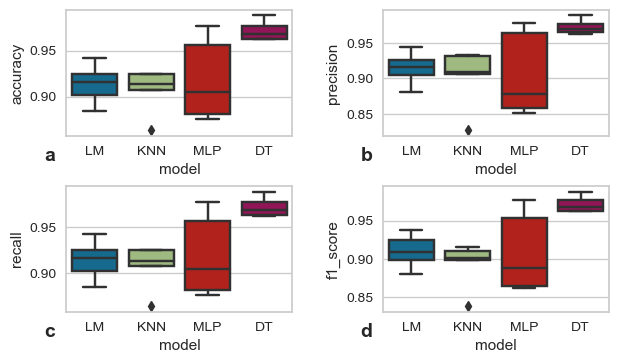

In [4]:
fig = plt.figure(figsize = (7,4),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=2,wspace=0.4,hspace=0.4)

metrics = ['accuracy','precision','recall','f1_score']
r = [0,0,1,1]
c = [0,1,0,1]
count=0

im = ['a','b','c','d','e','f','g','h']
for metric in metrics:
    ax = fig.add_subplot(axes[r[count],c[count]])
    sns.boxplot(y=results[metric],x=results['model'],ax=ax)
    ax.text(-0.1, -0.2, im[count], size=14, weight='bold', transform=ax.transAxes)
    count+=1
plt.savefig('fig_metrics.pdf', format="pdf", dpi=1000, bbox_inches="tight")

### Gerando matrix de confusão média e curva roc média por modelo

In [5]:
def models (name,parameters):
    if name == 'DT':
        model = DecisionTreeClassifier(**parameters);
    elif name == 'RF':
        model = RandomForestClassifier(**parameters);
    elif name == 'KNN':
        model = KNeighborsClassifier(**parameters);
    elif name == 'LM':
        model = LogisticRegression(**parameters);
    elif name == 'SVM':
        model = SVC(**parameters);
    elif name == 'MLP':
        model = MLPClassifier(**parameters);
    else :
        print('Model not found')
        model=None
    return model

### Matrix média

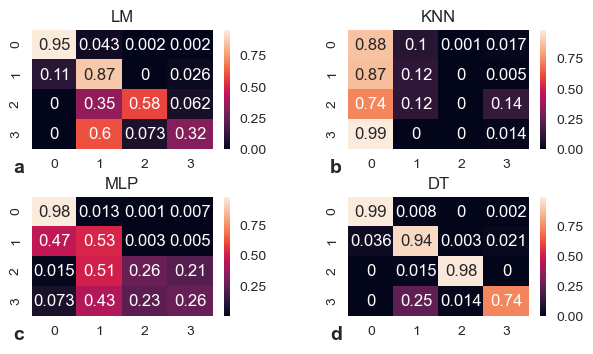

In [6]:
fig = plt.figure(figsize = (7,6),dpi=100)
axes = gridspec.GridSpec(nrows=3, ncols=2,wspace=0.4,hspace=0.4)

r = [0,0,1,1,2,2]
c = [0,1,0,1,0,1]

models_name = ["LM", "KNN", "MLP", "DT"]
 
count=0
for name in models_name:
  conf_mean = 0
  
  for k in range(1,6):
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino[features]
    y_treino = treino['class']

    x_teste = teste[features]
    y_teste = teste['class']
    
    res_model = results[results.model==name]
    parameters = literal_eval(res_model[res_model.fold==1]['parameters'].values[0])

    model = models(name,parameters);
    model.fit(x_treino, y_treino);
    y_pred = model.predict(x_teste);
    conf_mean = conf_mean + confusion_matrix(y_teste, y_pred,normalize='true')
    
  conf_mean = np.round(conf_mean/5,3)
  
  ax = fig.add_subplot(axes[r[count],c[count]])
  plt.title(name)
  sns.heatmap(conf_mean, annot=True,ax=ax,cmap="rocket")
  ax.text(-0.1, -0.2, im[count], size=14, weight='bold', transform=ax.transAxes)
  count+=1
plt.savefig('fig_confusion.pdf', format="pdf", dpi=1000, bbox_inches="tight")
plt.show()

### Curva roc média

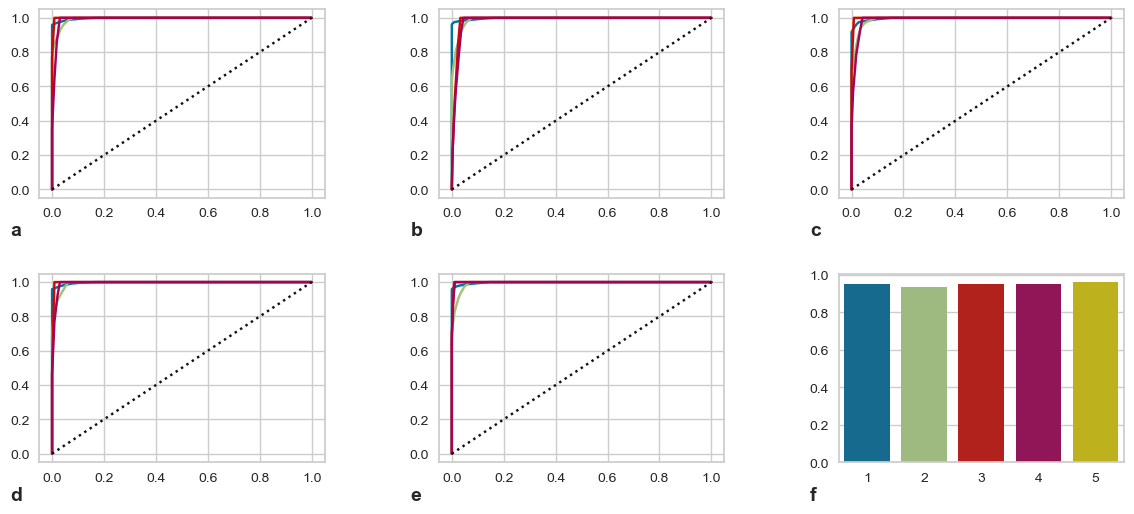

In [7]:
fig = plt.figure(figsize = (14,6),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=3,wspace=0.4,hspace=0.4)

r = [0,0,0,1,1,1]
c = [0,1,2,0,1,2]

models_name = ["LM", "KNN", "MLP", "DT"]
 
count=0
name='DT'
auc_ = []
for k in range(1,7):
  ax = fig.add_subplot(axes[r[count],c[count]])
  
  if k<6:
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino[features]
    y_treino = treino['class']

    x_teste = teste[features]
    y_teste = teste['class']
    
    res_model = results[results.model==name]
    parameters = literal_eval(res_model[res_model.fold==1]['parameters'].values[0])

    model = models(name,parameters);
  
    visualizer = ROCAUC(model, classes=["0", "1", "2", "3"],ax=ax,micro=False, macro=False)
    visualizer.fit(x_teste, y_teste)        # Fit the training data to the visualizer
    auc_.append(visualizer.score(x_teste, y_teste,))       # Evaluate the model on the test data
  
  
  else:
    sns.barplot(x=['1','2','3','4','5'],y=auc_,ax=ax)
    
  ax.text(-0.1, -0.2, im[count], size=14, weight='bold', transform=ax.transAxes)
    
  count+=1
plt.savefig('fig_roc.pdf', format="pdf", dpi=1000, bbox_inches="tight")
plt.show()

In [8]:
from cProfile import label


for c in range(0,4):
   
   print(roc_auc_score(y_teste[y_teste==c], model.predict_proba(x_teste)[y_teste==c,:],multi_class='ovr'))
   


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [303]:
print(model.predict_proba(x_teste)[y_teste==c,:].shape)
y_teste[y_teste==c].shape

(242, 4)


(242,)

In [304]:
print(model.predict_proba(x_teste).shape)
y_teste.shape

(345, 4)


(345,)